**Settings:**
Here are some settings that I put at the top of all my notes

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
import itertools
import pickle

Getting Pulses Using `pyRawIO` 
==============================

The SuperCDMS library `pyRawIO` allows us to read raw MIDAS DAQ files directly to get the raw pulses that our analysis RQs are based on. The library is hosted on the GitLab page for SuperCDMS [[GitLab:pyRawIO][GitLab:pyRawIO]]. The library `pyRawIO` depends on other libraries like `CDMSbats` and `ROOT`-- those are sometimes difficult to install so these instructions focus on using a `singularity` container [[Singularity][Singularity]] where all of that stuff is already pre-installed and all you need to run this is to install `singularity` and have the image files (which are maintained by SuperCDMS [[Singularity-Images][Singularity-Images]]). 

[GitLab:pyRawIO]: https://gitlab.com/supercdms/DataHandling/pyRawIO "GitLab:pyRawIO"
[Singularity]: https://docs.sylabs.io/guides/latest/user-guide/introduction.html "Singularity" 
[Singularity-Images]: https://confluence.slac.stanford.edu/display/CDMS/Using+Containerized+CDMS+Offline+Releases#UsingContainerizedCDMSOfflineReleases-WheretogettheSingularityimagesfrom? "SCDMS Singularity Image Registry"

Singularity
-----------

To begin using singularity you will probably have to install it, but test if you have it by typing `singularity --help` in the terminal; if that returns the help menu then you already have it! Singularity depends on go [[go][go]], so if you don't have it you will have to install that first. Install `singularity` and `go` according to the instructions in this repository [[example_scripts/singularity][sing-install]].

Here are some useful singularity images on disk on the UMN cluster:

 - `/data/chocula/villaa/cdmsfull_latest.sif` (don't remember exactly the SuperCDMS release tag, V04-12?)
 - `/data/chocula/villaa/cdmsfull_V04-07-00.sif`  
 - `/data/chocula/villaa/cdmsfull_V04-13-00.sif`
 
Before using `singularity` you should have the correct environmental variables set, this could be:

```
export GOCACHE="/data/chocula/villaa/.cache/go"
export GOMODCACHE="/data/chocula/villaa/.cache/go/pkg/mod"
export GOPATH="/data/chocula/villaa/go"
export CCACHE_DIR="/data/chocula/villaa/.ccache"
export PATH=$PATH:/data/chocula/villaa/goinstall/go/bin
export SINGULARITY_BINDPATH=/data
```

Most of these set up the paths and cache directories for the language `go` itself. Make the cache directories something that has some space. On the UMN cluster my home directory is severely limited so I used the data directory `/data/chocula/villaa`, other users should be able to make their own directory in `/data/chocula` if they don't already have one. Contact Anthony Villano to get help with setting that up if you don't have permission. 

Open a shell in `singularity` then you will have access to the code environments above created for SuperCDMS and having `pyRawIO`, `CDMSbats` and `ROOT` already installed.

```
$ singularity shell /data/chocula/villaa/cdmsfull_V04-13-00.sif 
WARNING: DEPRECATED USAGE: Environment variable SINGULARITY_BINDPATH will not be supported in the future, use APPTAINER_BINDPATH instead
Singularity> 
```

We also have the ability to run a Jupyter Labs server inside the `singularity` container and expose a web port that can be accessed by a browser outside. Many users typically work from remote locations, so below is the procedure for getting a singularity container running with a Jupyter Labs server and accessing it from a web browser. 

 1. Connect to UMN via VPN
 2. ssh to a UMN machine (maybe `cdms2.spa.umn.edu`) and map port 8889 to your localhost
 3. Spin up a `singularity` instance with a Jupyter Labs server running on port 8889 (this port should not conflict with any running Jupyter Lab instances on the UMN machine or your local machine)
 4. Open a web browser on your local machine with the address `https://localhost:8889`
 
 The first step is accomplished through your VPN client and two-factor authentication as normal. The second step can be accomplished (once the VPN connection is established) via this command on your localhost:
 
 ```
 $ ssh -L 8889:localhost:8889 user@cdms2.spa.umn.edu
 ```

The third step is accomplished in the newly opened shell to the UMN computer `cdms2.spa.umn.edu`. Use the following command:

```
$ singularity run /data/chocula/villaa/cdmsfull_V04-13-00.sif --no-browser --port=8889
```

After this step the terminal will display status updates for the `singularity` container that is running. You can check there to see if there are problems or if it's stalled (hit enter and you should see a new line if it's still running). The main thing that can stall the `singularity` instance is the VPN or other connections dropping. If it is the first time you've run this command you will see some output after it that gives you an authentication key to get into the Jupyter Lab instance for the first time (step 4). 

**Note:** if your connection breaks down at some point and the terminal stops responding it is likely that you _have not_ stopped your Jupyter Lab instance. You should be able to simply re-do the second step above. You will no longer have the `singularity`/Jupyter status updates in the terminal but you should be able to connect to and use the Jupyter instance as in step 4. In other words in the case of a broken connection where you want to re-connect to your previous Jupyter instance just do steps 2 and 4 again. 

If you would like to find and remove previous running instances of Jupyter Lab do:

```
$ ps -u user |grep jupyter-lab
```

Then kill all the processes you find like:

```
$ kill -9 PID
```

[go]: https://go.dev/doc/install "GO programming language"
[sing-install]: https://github.com/villano-lab/R76Analysis/tree/master/example_scripts/singularity "Installing Singularity"

Loading In Events
-----------------

The toolchain that was developed involves getting a text-file list of series/event numbers from our processed data. That list will be passed to the script `singularity_pulseSave.py` and it will produce a file called `pulses.pkl` that contains a data structure with all the requested pulses in it. What I (Anthony) have used in the past is a formatted file from Matt that shows various analysis quantities for events, then I select a subset of those to get the pulses for. **Note:** A set of around 1200 pulses will result in an output file from `singularity_pulseSave.py` of about 100 Mb. 

The formatted file from Matt looks like:

```
****************************************************************************************************************************************************
*    Row   *   SeriesNumber *    EventNumber *       pt_keVee *        coinwin *      PTOFdelay *   zip4.PAWKmax *   zip4.PAWKr50 *         cchisq *
****************************************************************************************************************************************************
*     6107 *    72209162200 *          70265 * 0.035492627470 *              0 *       5.92e-05 * 8.24276502e-07 * 0.000400652451 *              1 *
*    40145 *    72209162200 *         430871 * 0.099516752413 *              1 *        1.6e-05 * 8.27113601e-07 * 0.000405632437 *              1 *
*    40417 *    72209162200 *         440254 * 0.045830295421 *              0 *       3.92e-05 * 8.10276066e-07 * 0.000405238078 *              0 *
*    44615 *    72209162200 *         480783 * 0.036226841102 *              0 *       3.44e-05 * 8.13807932e-07 * 0.000405366383 *              1 *
*    45533 *    72209162200 *         490759 * 0.260436379674 *              0 *       3.44e-05 * 8.25049970e-07 * 0.000405464026 *              1 *
*    48298 *    72209162200 *         520788 * 0.035015524687 *              0 *       4.48e-05 * 8.34448512e-07 * 0.000405338227 *              1 *
*    54136 *    72209162200 *         590105 * 0.505873941394 *              0 *       4.64e-05 * 8.16696716e-07 * 0.000405465675 *              1 *
*    55791 *    72209162200 *         600805 * 0.085282336319 *              0 *       5.84e-05 * 8.34338783e-07 * 0.000405886791 *              1 *
*    60164 *    72209162200 *         650562 * 0.035800719635 *              0 *       5.36e-05 * 8.32320110e-07 * 0.000405415123 *              1 *
*    64728 *    72209162200 *         700360 * 0.036148316644 *              0 *        4.8e-05 * 8.01631662e-07 * 0.000405576181 *              1 *
*    73880 *    72209162200 *         800237 * 0.040017307227 *              1 *       1.28e-05 * 8.03877571e-07 * 0.000405295972 *              1 *
*    84589 *    72209162200 *         910814 * 0.039486779722 *              0 *        2.4e-06 * 8.17602531e-07 * 0.000405210718 *              1 *
...
```

This is the head of the file in this repository `coin_analysis/data/r76_roi_events_trig_set1.txt`. The code below will read in three such files for triggered events in this repository. It puts the information in a `Pandas` DataFrame. 

In [2]:
#fetch the data from the file from Matt formatted as above:

coindata1 = pd.read_csv("../coin_analysis/data/r76_roi_events_trig_set1.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','pt_keVee','coinwin','PTOFdelay','zip4.PAWKmax','zip4.PAWKr50','cchisq'], \
            delim_whitespace=False)
coindata2 = pd.read_csv("../coin_analysis/data/r76_roi_events_trig_set2.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','pt_keVee','coinwin','PTOFdelay','zip4.PAWKmax','zip4.PAWKr50','cchisq'], \
            delim_whitespace=False)
coindata3 = pd.read_csv("../coin_analysis/data/r76_roi_events_trig_set3.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','pt_keVee','coinwin','PTOFdelay','zip4.PAWKmax','zip4.PAWKr50','cchisq'], \
            delim_whitespace=False)
coindata4 = pd.read_csv("../coin_analysis/data/r76_roi_events_trig_set4.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','pt_keVee','coinwin','PTOFdelay','zip4.PAWKmax','zip4.PAWKr50','cchisq'], \
            delim_whitespace=False)
frames = [coindata1, coindata2, coindata3, coindata4]


coindata = pd.concat(frames)
print (coindata.head(10))

   garbage    Row  SeriesNumber  EventNumber  pt_keVee  coinwin  PTOFdelay  \
0      NaN   6107   72209162200        70265  0.035493        0   0.000059   
1      NaN  40145   72209162200       430871  0.099517        1   0.000016   
2      NaN  40417   72209162200       440254  0.045830        0   0.000039   
3      NaN  44615   72209162200       480783  0.036227        0   0.000034   
4      NaN  45533   72209162200       490759  0.260436        0   0.000034   
5      NaN  48298   72209162200       520788  0.035016        0   0.000045   
6      NaN  54136   72209162200       590105  0.505874        0   0.000046   
7      NaN  55791   72209162200       600805  0.085282        0   0.000058   
8      NaN  60164   72209162200       650562  0.035801        0   0.000054   
9      NaN  64728   72209162200       700360  0.036148        0   0.000048   

   zip4.PAWKmax  zip4.PAWKr50  cchisq  
0  8.242765e-07      0.000401       1  
1  8.271136e-07      0.000406       1  
2  8.102761e-07      

Once I have this data in a `Pandas` DataFrame I can use `numpy` arrays to select the Series/Event numbers I want based on some criteria. Below I select all of the events that have a good or bad `cchisq` (Chisquare cut) and energy over 100 eV. The slicing can be done in the `Pandas` DataFrame directly, but I prefer `numpy` arrays. 

In [3]:
#put relevant RQs data into numpy arrays
series = np.asarray(coindata['SeriesNumber'])
ev = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
ccoinwin = np.asarray(coindata['coinwin'],dtype=np.dtype(bool))
cchisq = np.asarray(coindata['cchisq'],dtype=np.dtype(bool))

#get cut for good/bad chisquare
csiggood = (EkeV>0.1)&cchisq
csigbad  = (EkeV>0.1)&~cchisq

#print out number of each events
print('{} good chisquare events'.format(np.sum(csiggood)))
print('{} bad chisquare events'.format(np.sum(csigbad)))

128 good chisquare events
141 bad chisquare events


Then I place, for example, the good Chisquare events into a text file with simply the `SeriesNumber` and `EventNumber` RQs. 

In [4]:
with open('goodchi.txt', 'w') as f:
    for i,s in enumerate(series):
        if(csiggood[i]):
          f.write('{} {}\n'.format(s,ev[i]))

This file looks like this:

```
72209162200 490759
72209162200 590105
72209162200 970769
72209162200 990193
72209162200 1200805
72209162200 1920692
72209162200 2640676
72209162200 3320285
72209162200 3470461
72209162200 5310198
72209171225 1500320
72209171225 1970453
72209171225 2280315
72209171225 2920809
72209171225 3240861
72209171225 4530720
...
```

It will be used as input to the `singularity_pulseSave.py` script to fetch the raw pulses. 

`singularity_pulseSave.py`
-------------------------

This script **must** be run on a machine where the data is mounted within the `singularity` container. I typically use `cdms2.spa.umn.edu` and connect to it by VPN/ssh. 

 1. Spin up a `singularity` shell at UMN or wherever has access to the raw data
 2. Go into the `python` directory of this repository
 3. Execute the `singularity_pulseSave.py`
 4. Copy the output `pulses.pkl` to wherever you want to read the pulses from could be through the UMN/singularity Jupyter or could be on your local machine. You should only need the `pickle` Python library to read the pulses if you have this file. 
 
 
 For Step 1, I do two sub-steps. First, connect to the UMN cluster (I do not have raw data locally):
 
 ```
 $ ssh avillano@cdms2.spa.umn.edu
 ```
 
 Then I start up a singularity container like:
 
 ```
 $ singularity shell /data/chocula/villaa/cdmsfull_V04-13-00.sif 
 ```
 
 I then make sure I have a checked-out version of the `R76Analysis` repository on the UMN computers and move into the `python` directory, that's Step 2. 
 
 In the `singularity` shell I then execute the following command to invoke the `singularity_pulseSave.py` script:
 
 ```
 Singularity> python3 singularity_pulseSave.py --evlist=../example_scripts/goodchi.txt 
 ```
 
 **Note:** this input file is the text file that was made in the previous section, containing all events over 100 eV passing the Chisquare cut. 
 
 The output of this command will be lots of text to the terminal window and a single file in the `python` directory called `pulses.pkl` for Step 4, move that file to the repository directory `example_scripts` (the directory where this note sits). 
 
 ```
 Singularity> mv pulses.pkl ../example_scripts/
 ```

Reading Back Events
-------------------

Having the `pulses.pkl` file and the `goodchi.txt` file in our working directory (`example_scripts`), we can now look at the pulses that we've fetched alongside the Series/Event data. 

In [5]:
#read the pkl file from pulses
fileObj = open('pulses.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()

In [6]:
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('goodchi.txt')

   SeriesNumber  EventNumber
0   72209162200       490759
1   72209162200       590105
2   72209162200       970769
3   72209162200       990193
4   72209162200      1200805
5   72209162200      1920692
6   72209162200      2640676
7   72209162200      3320285
8   72209162200      3470461
9   72209162200      5310198
[72208301829 72208302118 72208311151 72209162200 72209171225 72209172155
 72210191832 72210192240 72210200954 72210251956 72210261049 72210262224
 72210270959]
[550152 610538 620687]
[  70193  340676  530225  580726  920658 1220460 2520826 2560339 2690376
 3360712 3400635 3950868 4010638 4240150 5020188 6020421 6110497 6280605]
[1320198 1630263 1950136 2970369 3650606 3670094]
[ 490759  590105  970769  990193 1200805 1920692 2640676 3320285 3470461
 5310198]
[1500320 1970453 2280315 2920809 3240861 4530720 4950597 5080366]
[1220647 1520104]
[ 500590  680460 1000312 1000698 1430424 1560356 1640702 1690511 1931161]
[ 300587 1451328 1580294 1840013 2331140 2840178 3130642 319

72208301829
550152
[3075 3076 3077 ... 3073 3073 3073]


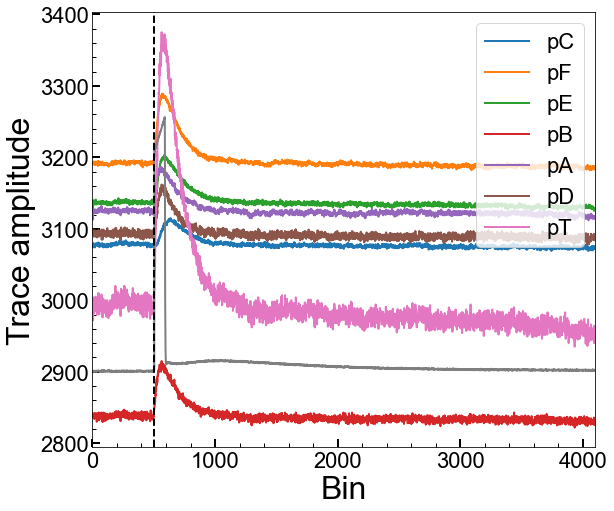

72208301829
610538
[3204 3147 3148 ... 3140 3146 3143]


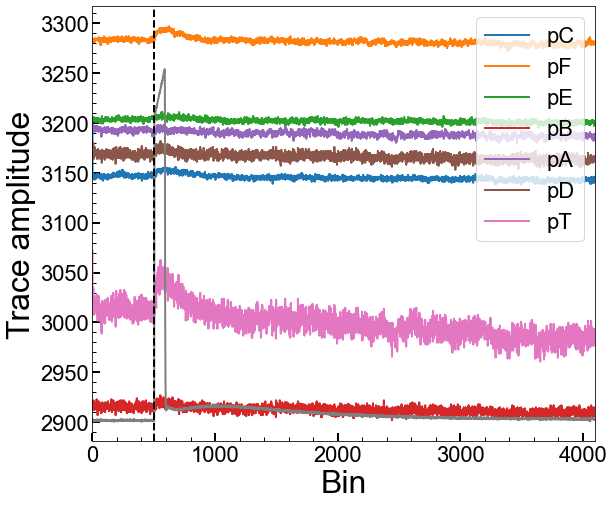

72208301829
620687
[3058 3055 3058 ... 3051 3049 3049]


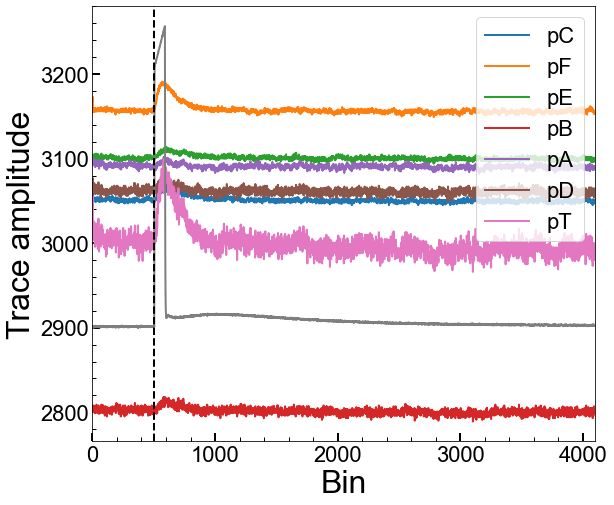

72208302118
70193
[3048 3051 3046 ... 3043 3042 3043]


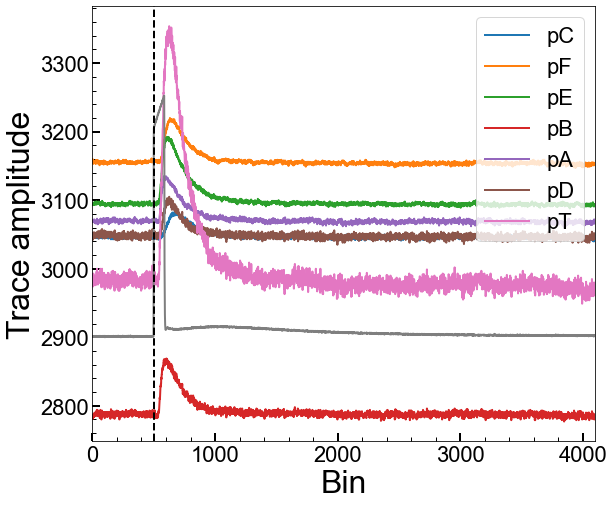

72208302118
340676
[3070 3068 3067 ... 3059 3058 3058]


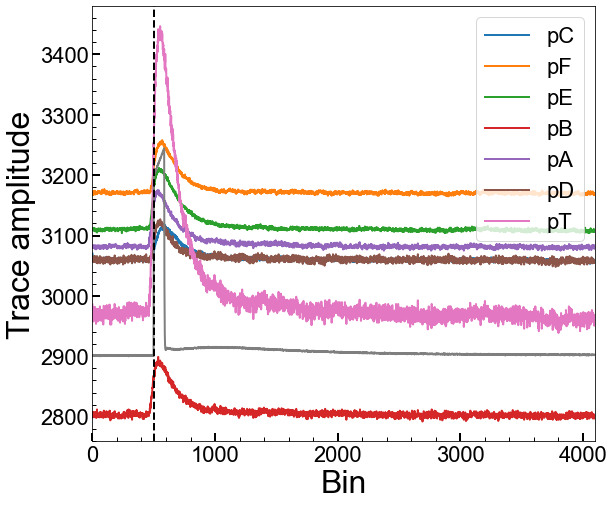

72208302118
530225
[3074 3075 3075 ... 3071 3072 3072]


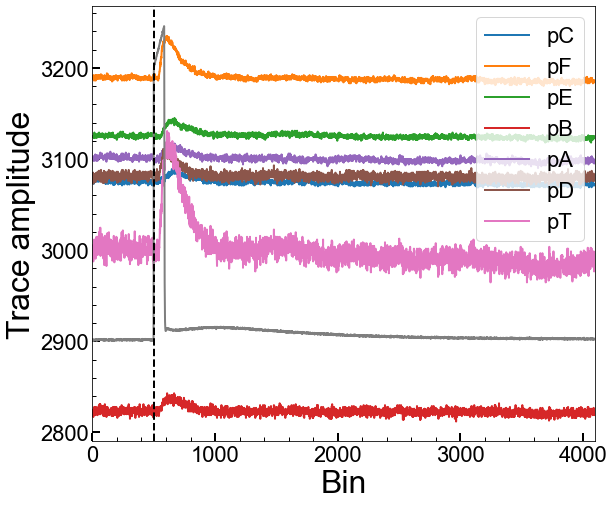

72208302118
580726
[3042 3041 3044 ... 3041 3040 3043]


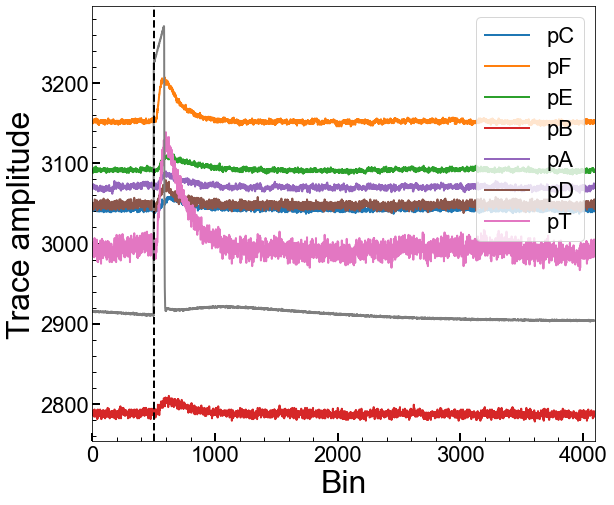

72208302118
920658
[3079 3081 3081 ... 3077 3079 3078]


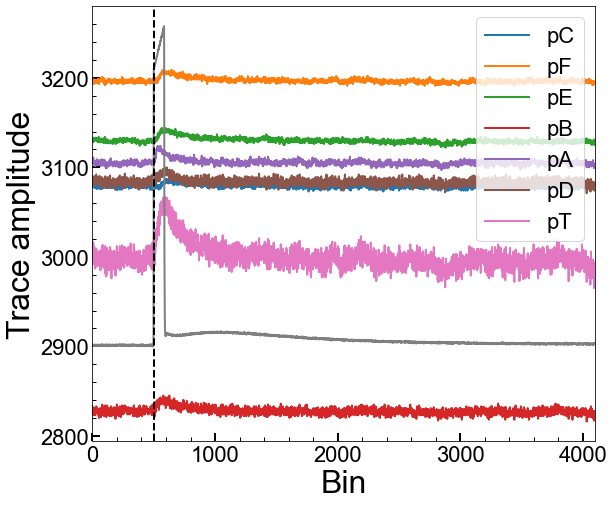

72208302118
1220460
[3127 3132 3127 ... 3161 3162 3161]


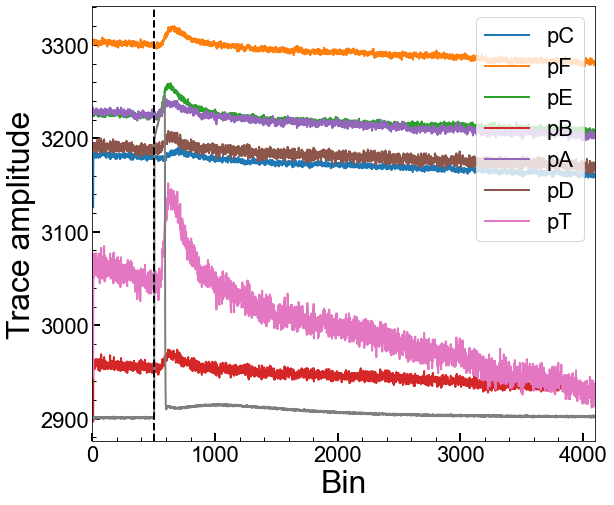

72208302118
2520826
[3148 3146 3147 ... 3148 3147 3148]


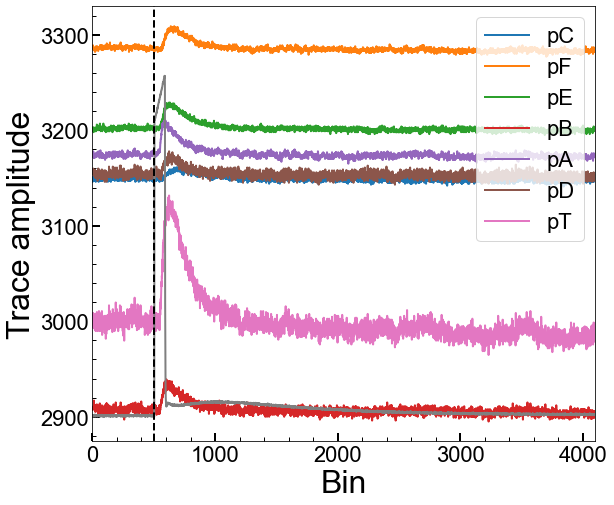

72208302118
2560339
[3104 3103 3103 ... 3103 3102 3101]


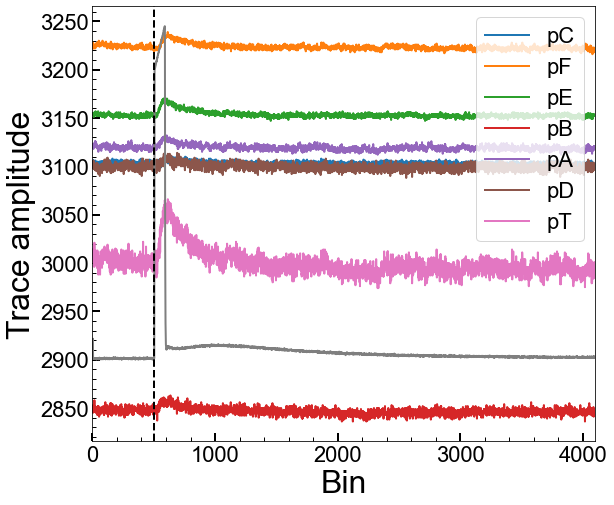

In [7]:
#loop over some of the events and plot
count=0
for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
      
    
      if count>10:
        continue
      
      count+=1
      print(ser)
      print(ev)
      fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
      ax1 = axes
      print(exampleObj['Z1']['PA'][ser,ev])
      shownpulses=0

      #plt.subplot(8,12)
      if(not pa.isRailed(exampleObj['Z1']['PA'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
      if(not pa.isRailed(exampleObj['Z1']['PB'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
      if(not pa.isRailed(exampleObj['Z1']['PD'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
      if(not pa.isRailed(exampleObj['Z3']['PA'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
      if(not pa.isRailed(exampleObj['Z3']['PB'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
      if(not pa.isRailed(exampleObj['Z3']['PD'][ser,ev])):
        shownpulses+=1
        ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")

      if(shownpulses>0):
        ax1.plot(pa.getPTPulse(exampleObj,ser,ev)+3000,label="pT")

      ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
      #plt.title('PA')
      ax1.legend(loc=1,prop={'size':22})
      ax1.set_xlim(0,4096)
      ax1.set_xlabel('Bin')
      ax1.set_ylabel('Trace amplitude')
      plt.axvline(x=500,color='k',linestyle="--")

      #plt.suptitle('Event 0 on Z1 PA Channels')
      if(shownpulses>0):
        plt.show()